#    
# Project Proposal and Update: Single-game skill rating predictor for Chess

Tyler Mark Ahlstrom
<br>
April-May 2018
#   

## Abstract

I propose improving the current ranking and matchmaking system used in many online games by enabling stronger early estimates of player skill. Using millions of engine-analyzed game performances, I will train a model capable of approximating the skill rating of a player after observing only one of their games. This project would focus exclusively on chess, although the approach has more general application. 




<br>
###### Update #1 (May 2018): 
New performance data was generated by running a Stockfish engine analysis on 750 games downloaded from lichess. This data has a more even Elo distrubution, and reproduces the previously observed trends more cleanly. Several different engine speeds were sampled in order to determine appropriate settings prior to large-scale data generation.

Using the low quantity of data generated thus far, 10 features were selected and used to train NN-based models. These models were able to predict player Elo with an average error of ~200 points based only on a single game performance, and without any explicit information about the opponent. This is about a 25% improvement over simple models than always predict the mean Elo of the training set.

Surprisingly, the model that best predicts Elo based on a single performance is quite poor at predicing whether the performance lead to a win, loss, or draw. 

Strong imporovements are expected with more data and more thorough feature exploration.
#   

## Overview

### The problem being addressed:

Current ranking and matchmaking systems for online games are based on the classic [Elo system](https://en.wikipedia.org/wiki/Elo_rating_system) or one of its [many variants](https://en.wikipedia.org/wiki/Glicko_rating_system), so widely used that 'Elo' is largely synonymous with 'skill rating'. These systems are all results-focused in that they care about who wins, but not *how* the game was played. While these systems eventually have very strong estimates of player skill, they are slow to achieve these estimates (despite usually having a flexible [K-factor](https://en.wikipedia.org/wiki/Elo_rating_system#Most_accurate_K-factor)). This has the effect that players on new accounts often have to (or in the case of 'smurfing', *get to*) play many games against players of much higher or lower skill before they are matched with opponents of similar skill. The existence of this problem is corroborated by the stronger dependence between win percentage and rating for accounts with fewer games (fig. 1 below). To deal with this problem, companies have various strategies, such as limiting the number of accounts a user can create, or forcing players to play several 'placement' games before giving them a rating at all. These strategies all have notable downsides. I propose an alternative approach.

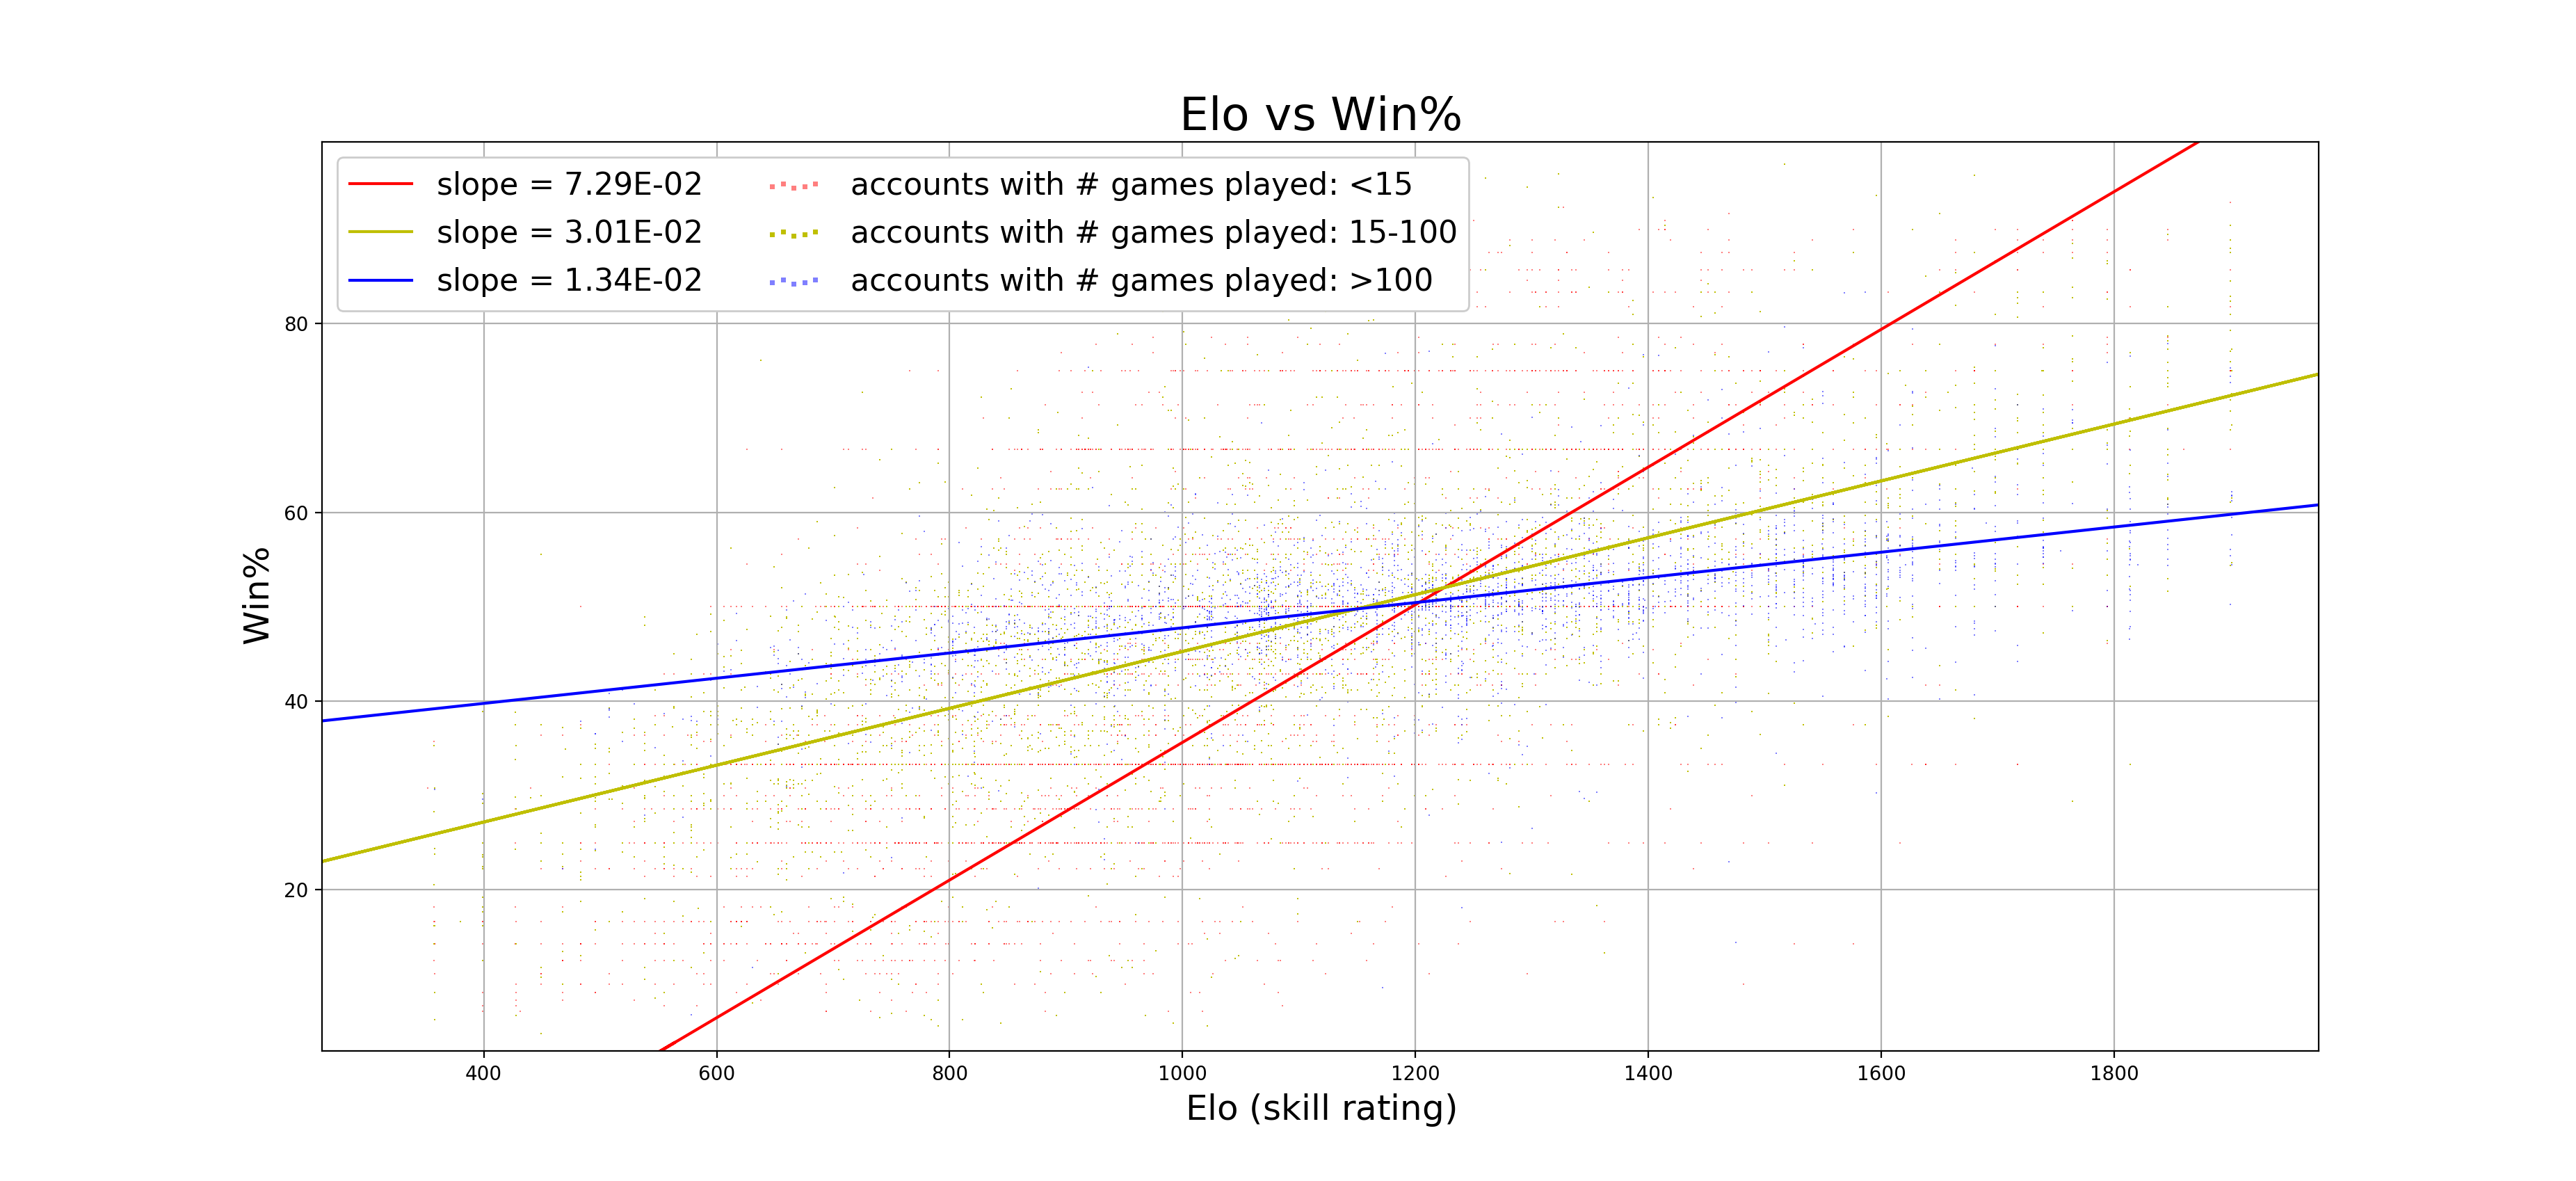

In [3]:
from IPython.display import Image, display
display(Image(filename='images/elo_vs_winpercentage.png', embed=True))

###### Figure 1
The Elo and win percentage of 18k accounts were scraped from https://www.chess.com/leaderboard/live/rapid. The greater dependence between Elo and win percentage for accounts with fewer games is indicative of how slowly Elo-based rating systems are to accurately estimate player skill.

### How I propose to address this problem:

Engines have been developed for many games that are capable of evaluating the merit of decisions made within a single playing of the game. By processing games with these engines, more information is generated that should be useful for establishing a skill rating: for a given play of the game, you may only win or lose once, but you make many decisions of various merit. A deep learning model trained on this engine-generated information should be able to approximate player skill ratings much more quickly than systems based only on win/loss data. 

I will tackle this problem for chess, which is a natural candidate given the availability of millions of games as well as many analysis engines from which to choose. Notwithstanding my focus on chess, many other games meet these requirements, including many online card games and, more recently, MOBAs and other action/strategy games. The general approach I'm pursuing holds promise for these games as well.


<br>
## Methodology:


### Getting the raw game data:

In order for my model to have commerical potential, it must be accurate for a wide range of skill levels--not just those at the top. Fortunately, the widely used site [lichess](https://lichess.org/) now releases the move-by-move game results (.pgn's) for most of their games, including those played by lower skilled players. These can be dowloaded directly from https://database.lichess.org/

This step is already done.

### Processing the raw data through a chess engine:

The Stockfish chess engine has recently been integrated with python: https://pypi.org/project/stockfish/. I have scripts ready to recieve a mass of .pgn data and, for each game, cycle through the positions and store the engine's evaluation (see 'code' folder). The speed at which Stockfish evaluates the positions can be adjusted, but is fairly accurate after only a second or two on a personal computer (so about 30-60 seconds per game). As the goal of this project is a quick and approximate estimation of player skill, a top-tier engine analysis will not be necessary.

As I am already set up to run this processing, this step should take a couple weeks at most, even if done on my local system.

### Constructing features from the processed results:

With the positions of each game evaluated, the strength of each move can be quantified as the difference in the favorability of the board for the mover before and after each move. This data promises to be hugely useful for a deep learning model. Below is an inital exploration of two manually determined features using this engine-generated data (fig 2). 

It is already interesting to note that not only is the average strength of a player's moves (throughout a single game) correlated with skill, but so too is the variation in the strengh of their moves--stronger players rarely make moves that wildly shift Stockfish's evaluation of the board. (Note the strength of moves tends to be negative because Stockfish is stronger than human players; also note that the odd strengh of the lowest tier players is likely due to a smaller sample size, see figure description.)

Yet additional features are worth constructing, such as the average & std of move strength after a small number of moves (likely helpful since the end game can become chaotic in terms of positional analysis).

Exploring for useful features will be done in conjunction with the following step, which will take the majority of my time.

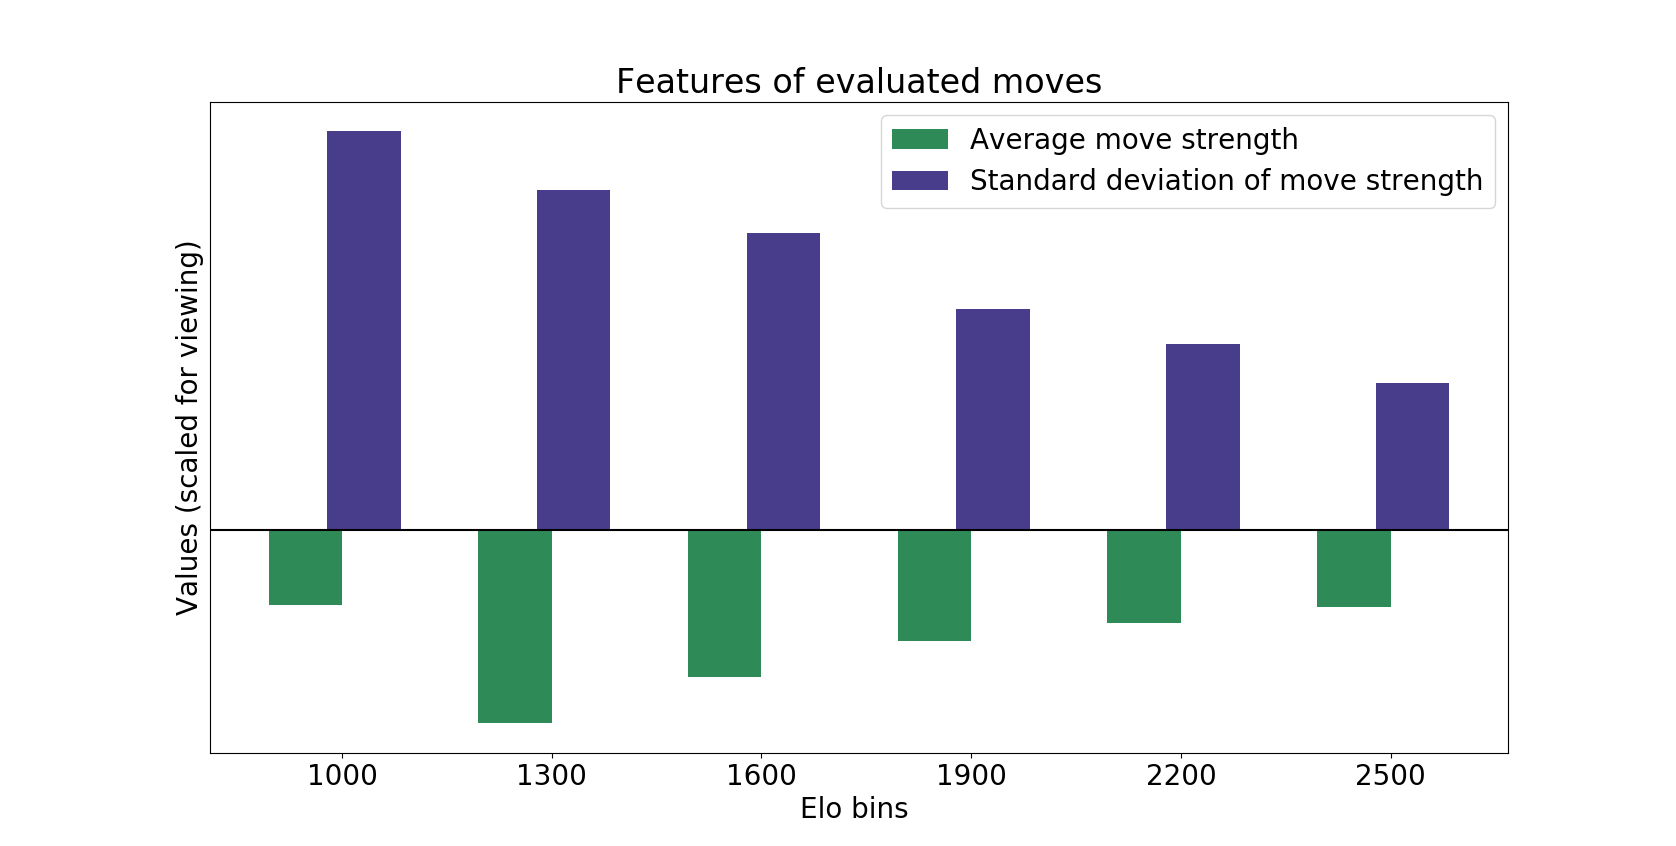

In [4]:
display(Image(filename='images/features_of_evaluated_moves.png', embed=True))

###### Figure 2 
I intended to generate this data on my own using my local Stockfish engine and the games taken from lichess. While this setup is operational and will work in the long run (~30 seconds per game), I used an alternative source of data for the purposes of this application: https://www.kaggle.com/c/finding-elo/data, containing evaluations of 12k games. A major problem with this data source is its low representation of lower skilled players (about 1% of the games), which likely explains the oddly strong average strength of their moves.

### Training a deep learning model:

As mentioned, the engine-generated data should be hugely beneficial to a deep learning model trained to estimate the Elo of players. There are two general model structures I would like to contruct:

1. **A standard deep neural network with a large number of input features, such as:**
    * Those extracted from the engine analysis:
       * Average strength and std/variance of moves over the entire game
       * Average strength and std/variance of first 5 moves
       * Average strength and std/variance of first 10 moves
    * Those extracted from the game data without using the engine:
        * Opponents Elo (although, see next section)
        * Length of game
        * Number of moves before queen moves
        * Whether/when castle occurs  
<br>
<br>
2. **A deep RNN only containing the strengh of each move as input**
<br>
<br>

Through coursework and independent exploration, I am already familiar with these model structures and the TensorFlow package. That being said, I expect this step to take the majority of my time due to the time requried to train the networks and tweak the hypterparameters. 


<br>
## Additional Direction:
Given the time...

### Coding a skill-flexible bot to play person of unknown skill while simultaneously estimating their skill:

I would like to build a website where people can go to play against a computer and receive an estimate of their chess rating after only one game. This site is tentatively called howgoodmechess.com. 

There is one possible hurdle for accomplishing this. Whether or not the above models are capable of accurately estimating a player's skill without knowing the skill of their opponenet is an outstanding question. That is, the opponent skill may need to be an input in the above models (though this would not be a significant problem).

If the opponent skill is *not* requried, building this bot would be easy: I would just need to pick a difficulty setting for a standard Stockfish engine (for example). 

If the opponent skill *is* required, then what at what skill level should this bot play? Presumably, the closer it is to the human's skill, the more accurate the estimate of the their skill rating (given that most data will come from such conditions). Accordingly, I would need the bot to estimate the human's skill on the fly, and play near their skill level. The latter task--modulating the skill of the bot--is trivial given modern engines. The former task--estimating the skill of the human on the fly--may require some additional modeling efforts (e.g., training on partial games). 




<br>
# Update #1
May 2018
<br>

## Summary 

<br>
My chess-engine processing of raw game data is operational, and simple NN-based models have been trained on this data. These models are able to predict the Elo of players, based only on a single game 'performance', with an average absolute error of ~200 points and an r<sup>2</sup> of .39. 

<br>
Significant improvements are expected once:
* More games are processed; there remains the problem of overfitting. Due to time spent exploring different engine speeds (see below), only 1k performances have been processed. 


* Model features are more carefully developed and selected. While I would like to rely on the engine evalutions as much as possible (see below for a list of my current features), the addition of hand picked features (e.g., when the queen is first moved) would likely help the model. There has been no systematic feature selection process. 


* Model hyperparameters are systematically explored. Relatively little time has been spent exploring the effect of the size and number of hidden layers, different learning rates, and so on. (This has so far been a lower priority than figuring out how I will be processsing the raw game data.) See below for current parameters.

## Game Processing

<br>
Raw game data (pgn files) were downloaded from the [lichess database](https://database.lichess.org/), and the [Stockfish chess engine](https://stockfishchess.org/) was used to generate positional evaluations after each move in the raw game data. The quality of each move was approximated as the difference in the favoriability of the position (for the player making the move) before and after the move. The 'performance' (list of move qualities) of each player was separated as a different data point, used later for model training. By separating the performances, I hope to make the model capable of estimating a players skill regardless of the skill of their opponent. While one may reasonably suspect this separation will always be a source of model error, initial efforts suggest this error is managable.

<br>
Game results (win/loss/draw) were not included in the performance data, keeping in line with the spirit of the project. Again, the goal is to develop a model that does well despite not knowing anything about the 

<br>
The engine allows for control over the amount of time taken to evaluate each position. Before deciding on a time and processing a large amount of games, I processed the same 750 games (1k performances) using three different time settings (0.5, 1, and 3 seconds per position). After making a quick NN-based model and training it on these three sets of data, the model performances suggests that one second evaluations is the best option. However, I plan to process about 10 times the current number of game for all time settings before I committ to this. 

<br>
Code for this processing can be found [here](code/stockfish_analyzer).

<br>

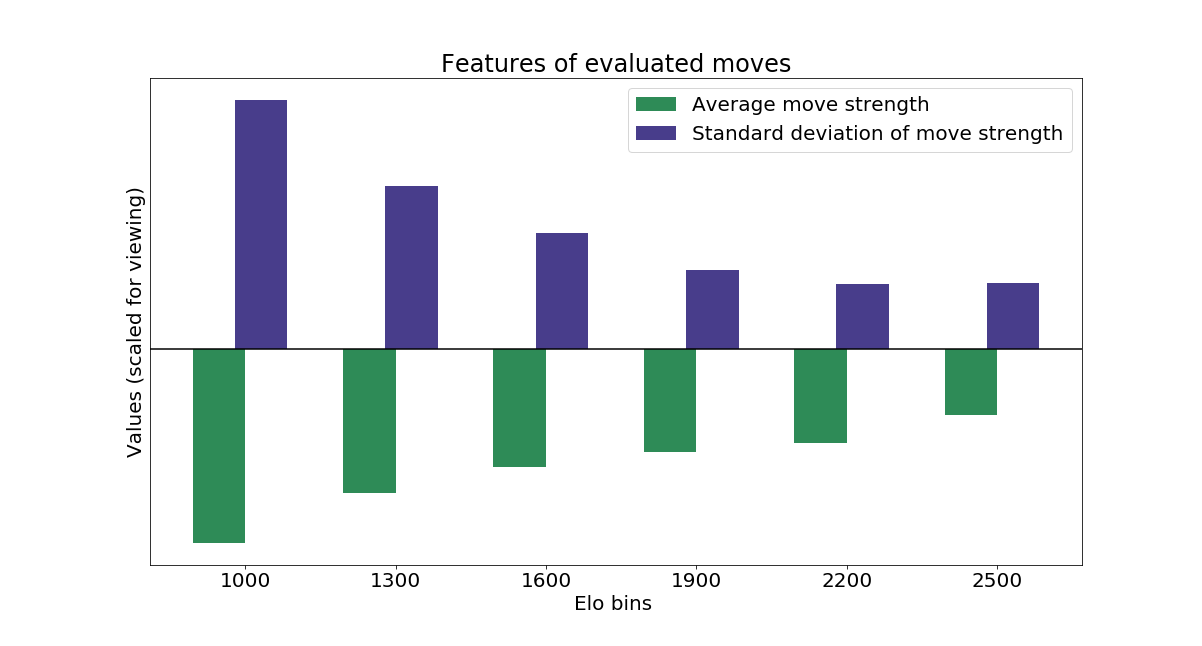

In [5]:
display(Image(filename='images/features_personal_data.png', embed=True))

###### Figure 3
Compared to Figure 2 (above), the data set that I generated myself has a better Elo distribution, and as a result, nicer trends. Once again, as one might expect, stronger players make stronger moves and are more consistent in their move strength. These and related features are used to train the models.

## Developing features from the processed results

<br>
Currently, all features (18 total) are developed from the Stockfish evaluations (except for the length of the game). These include: 

* The average and standard deviation of the strengh of the first 5, first 10, and all moves (6 features)
* The sum of the strenght of the first 5 and 10 moves (2 features) 
* The square of each of the above features (8 features)
* The number of moves in the performance, or the length of the game (1 feature)
* And for additional testing, the result of the game: win, loss, or draw (1 feature)

<br>
These features were selected using a rough trial and error process; no systematic feature selection has yet been carried out. 


<br>
There are additional, non-engine-related features that would surely improve the predictive accuracy of the model, such as: the point at which key moves occur (e.g., moving the queen, castling) and the 'opening' or first 5-10 moves (which can be cross refereced with databases that evaluate the different openings). However, I worry including these features would hinder my ability to accurately evaluate the skill of opponents who differ greatly in skill (see "Additional Direction" above for motivation for being able to do this). For example, a highly skilled player who is playing against a low skilled player will not execute a 'strong' opening if their oppnenet makes wild and weak moves early on; they should rather capitalize on these weak moves, and diverge from textbook openings. The moves of the skilled player would still be strong according to the engine analysis, though their opening would likely be considered weak. For this reason, I would like to make the most of the enginge-generated features, and only resort to these hand-designed features if model performance plateaus early. 

## Model training

<br>
Simple neural network models, as well as yet a simpler regression model, were trained on the above data. While all NN models had a single hidden layer, differet sizes for this layer were tested for each dataset. Explored sizes include 2, 4, 6, and 8 nodes in the hiddel layer, and whichever model performed best was selected. Likewise, random_states in the range of 0-9 were explored for each model using each dataset, and the top performing state was chosen. Due the the small amount of data generated thus far, the Limited-memory BFGS solver was used. 10% of the data was used as the test set. 

model = MLPRegressor(hidden_layer_sizes=(4,),
        activation='relu',
        solver='lbfgs',
        alpha=0.00001,
        max_iter=100000,
        learning_rate_init=0.001,
        tol = 0.000001,
        warm_start=True,
        random_state = 0)

<br>
A summary of results can be seen in the table below, where results from the top performing model for each dataset are reported. As a proof of concept, this development is a success. Both the linear regression and NN models do significantly better than the null model (which always predicts the mean Elo in the training set), improving the average absolute error by 23-27%.

<br>
As game results (win/loss/draw) were not included in the performance data, I explored the extent to which this information was 'contained' in the performance data. The model that best redicted Elo for each dataset was then used to predict the game outcome. To my surprise, it was quite poor at doing so; apparently, there is very little correlation between performance as I've measured it, and game outcome. While this is a bit counterintuitive, I beleive it can be rationalized by the fact that because player skill is being estimated based on their performance in the single game, the model has no way of determining whether that game performance was better or worse than might be expected based on their true Elo. Put differently, the error that remains in the Elo estimation (and perhaps always will, due to natural performance variation) hides the information needed to predict outcome from performance, namely, whether this performance was unusally strong or weak for the given player.  

<br>
Code for feature development and model training (rather messy at the moment) can be found [here](code/feature_selection_and_model_building).


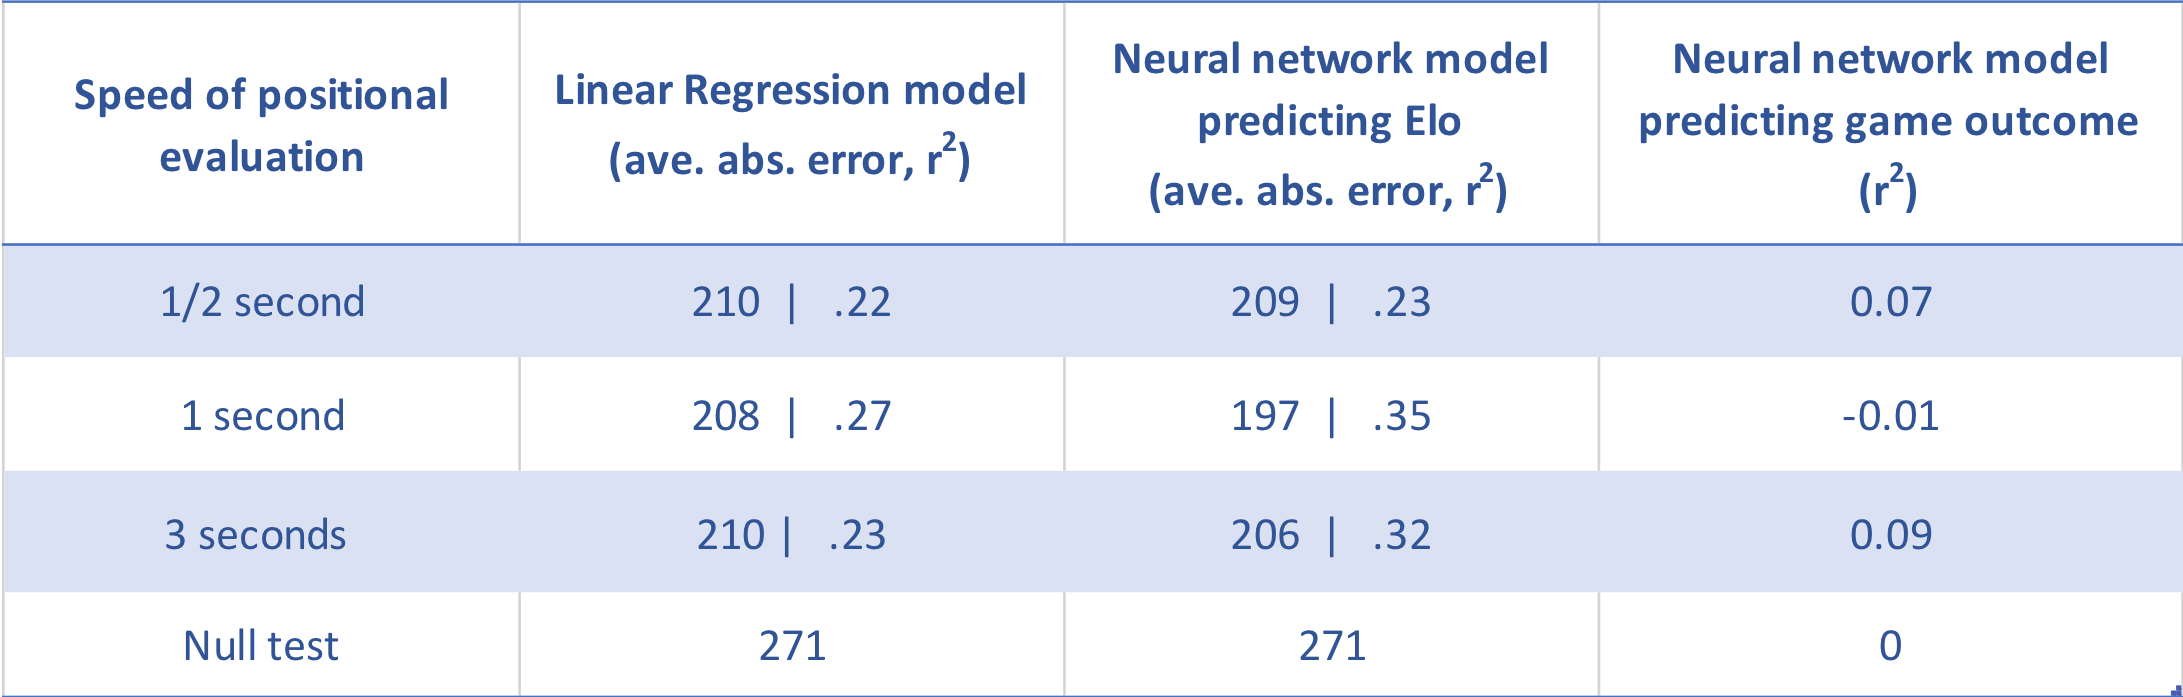

In [1]:
display(Image(filename='images/model_results.png', embed=True))

###### Figure 3
The performance of different models using three different datasets. For reference, player elo ranges from ~800 to ~2700, with an average of ~1650. The null test always estimates the player Elo to be the mean of the Elos in the training set. 


<br>
## Sources and notable resources:

chess.com leaderboards (used for scraping): https://www.chess.com/leaderboard/live/rapid

lichess.com database (used for collecting millions of raw game data): https://database.lichess.org/

Stockfish engine (used for processing raw game data in Python): https://pypi.org/project/stockfish/

Kaggle data set (used as a quick source of *problematic* data only for the purpose of this proposal):
<br>
https://www.kaggle.com/c/finding-elo/data

<br>
